#CafChem tools for deforming decomposition analysis on tabular data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/DecompositionAnalysis_CafChem.ipynb)

## This notebook allows you to:
- Upload a SMILES dataset and featurize it with RDKit features (you can use your own features as well)
- perform and view a plot of either PCA or t-SNE decompisition analysis in 2 dimensions

## Requirements:
- This notebook will install rdkit
- Will run fine on a CPU with rdkit and scikitlearn installed

## Set-up

### Install RDKit

In [1]:
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 45.7 MB/s eta 0:00:00:00:0100:01


### Import Libraries

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/statin905/905-unique-statins.csv
/kaggle/input/maob-data/maobIC50_clean_FINAL.csv


### Define functions

In [3]:
def rdkit_featurize(smiles_list: list, target_list: list, print_flag: bool):
  '''
    Takes a list of SMILES strings and creates features using the RDKit set of
    descriptors.

      Args:
        smiles_list: List of SMILES to featurize
        target_list: list of the ground trutch values for each molecule
        print_flag: True: print the number of descriptors for each molecule
                    FAalse: do not print anything
      Returns:
        X: 2D list of features (rows are molecules, columns are features)
        y: list of target values
        mols: list of RDKit mol objects
        legend: list of SMILES strings (should be identical to input list,
                unless a molecule could not be featurized, in which case that molecule
                is left out)
  '''
  X = []
  mols = []
  legend = []
  y = []
  add_flag = True
  for i,smile in enumerate(smiles_list):
    try:
      mol = Chem.MolFromSmiles(smile)
      dictionary_descriptors = Chem.Descriptors.CalcMolDescriptors(mol)
      temp_vec = []
      for key in dictionary_descriptors:
        temp_vec.append(dictionary_descriptors[key])
        add_flag = True
      X.append(temp_vec)
      mols.append(mol)
      legend.append(smile)
      y.append(target_list[i])
      if print_flag:
        print(f"{len(temp_vec)} descriptors calculated for: {smile}")
        print("--------------------------------------------------------")
    except:
      print(f"Could not featurize molecule {i}")

  print(f"Total number of molecules: {len(X)}")
  print(f"Total number of descriptors per molecule: {len(X[0])}")

  return X, y, mols, legend

def check_for_nan(f: list, y: list, Xa: list):
  '''
    Accepts the features array, the targets list, and the SMILES list. Checks
    the feature array for NaN. Removes any rows with NaN from features, targets
    and SMILES.

      Args:
        f: 2D list of features (rows are molecules, columns are features)
        y: list of target values
        Xa: list of SMILES strings
      Returns:
        f: trimmed 2D list of features (rows are molecules, columns are features)
        y: trimmed list of target values
        Xa: trimmed list of SMILES strings
  '''
  f = np.array(f)
  y = np.array(y)
  Xa = np.array(Xa)
  nan_indicies = np.isnan(f)
  bad_rows = []
  for i, row in enumerate(nan_indicies):
      for item in row:
          if item == True:
              if i not in bad_rows:
                  #print(f"Row {i} has a NaN.")
                  bad_rows.append(i)

  print(f"Old dimensions are: {f.shape}.")

  for j,i in enumerate(bad_rows):
      k=i-j
      f = np.delete(f,k,axis=0)
      y = np.delete(y,k,axis=0)
      Xa = np.delete(Xa,k,axis=0)
      #print(f"Deleting row {k} from arrays.")

  print(f"New dimensions are: {f.shape}")

  return f, y, Xa

def decomp(X: list, decomptype = 'P', whiten=False, perplexity=30):
    '''
    '''
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    if decomptype == 'P':
        pca = PCA(n_components=2, whiten=whiten)
        pca.fit(X_scaled)
        X_decomp = pca.transform(X_scaled)
    elif decomptype == 't':
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        X_decomp = tsne.fit_transform(X_scaled)
        print(f"KL divergence: {tsne.kl_divergence_}")

    print(f"Shape is: {X_decomp.shape}")

    plt.figure(figsize=(8,8))
    plt.scatter(X_decomp[:,0],X_decomp[:,1])
    plt.xlabel("1st component")
    plt.ylabel("2nd component")

## Load Data

In [4]:
df = pd.read_csv('/kaggle/input/maob-data/maobIC50_clean_FINAL.csv')
df.head()

,Unnamed: 0,SMILES,IC50,logIC50
0,0,O=C1c2ccccc2-c2nnc(-c3ccc(Cl)cc3)cc21,912.01,2.960000
1,2,CC(C)Nc1cnccc1CN.Cl.Cl,2000000.00,6.301030
2,3,Cl.Cl.NCc1ccncc1NC1CC1.O,90000.00,4.954243
3,5,Cl.Cl.NCc1ccncc1NCC1CCCCC1.O,70000.00,4.845098
4,7,N#CCOc1ccc(OCc2cccc(Cl)c2)cc1C=O,300.00,2.477121


In [5]:
smiles = df["SMILES"].to_list()
ic50s = df["IC50"].to_list()

In [6]:
X, y, mols, legend = rdkit_featurize(smiles, ic50s, False)

Total number of molecules: 950
Total number of descriptors per molecule: 217


In [7]:
X, y, smiles = check_for_nan(X, y, smiles)

Old dimensions are: (950, 217).
New dimensions are: (950, 217)


## Analysis

Shape is: (950, 2)


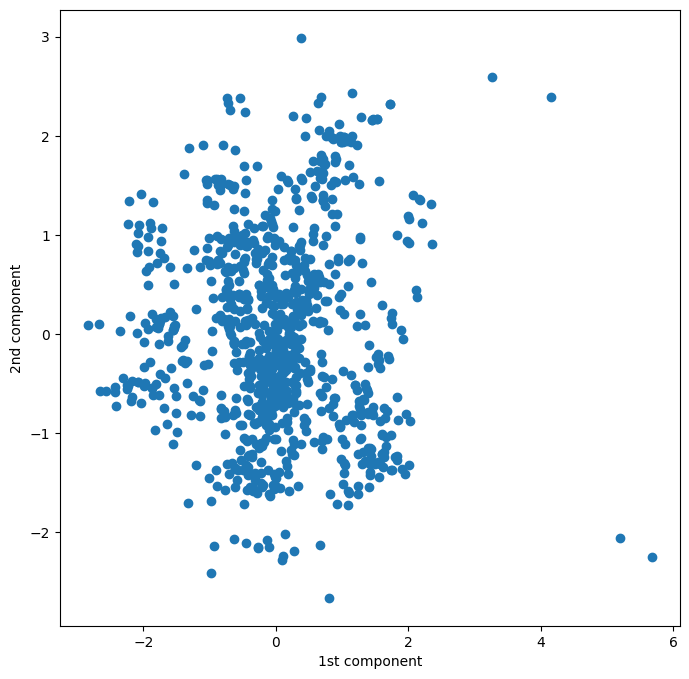

In [8]:
decomp(X, 'P', whiten=True)

KL divergence: 0.4989304542541504
Shape is: (950, 2)


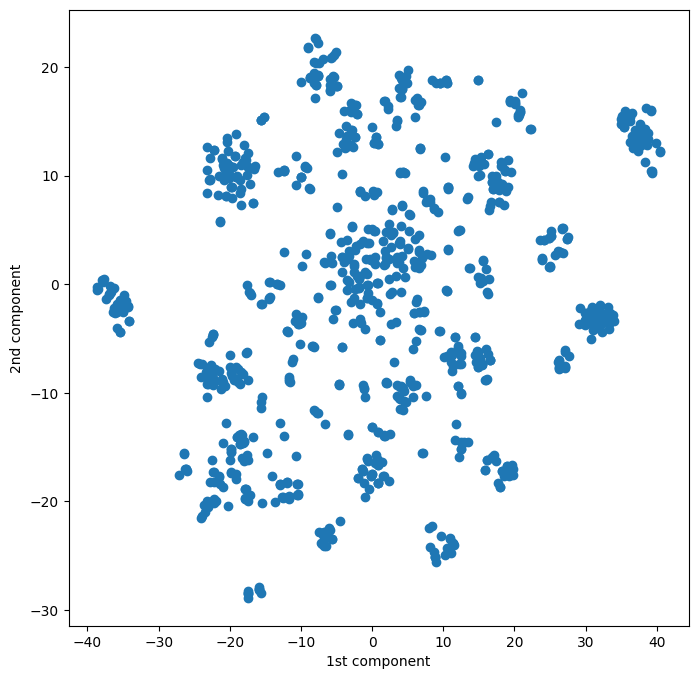

In [9]:
decomp(X,'t', perplexity=50)